In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [153]:
in_kdd = 46232
in_ids = 500000	
in_ciciot = 127298
in_kitsune = 96863	

kdd = pd.read_csv("kdd_FGM.csv")
ids = pd.read_csv("ids_FGM.csv")
ciciot = pd.read_csv("ciciot_FGM.csv")
kitsune = pd.read_csv("kitsune_FGM.csv")
credit = pd.read_csv("ecg_FGM.csv")

kdd['ratio'] = kdd['n2']*(1-kdd['r2'])/in_kdd
ids['ratio'] = ids['n2']*(1-ids['r2'])/in_ids
ciciot['ratio'] = ciciot['n2']*(1-ciciot['r2'])/in_ciciot
kitsune['ratio'] = kitsune['n2']*(1-kitsune['r2'])/in_kitsune
credit['ratio'] = credit['n2']*(1-credit['r2'])/in_kitsune

kdd['name'] ='kdd'
credit['name'] ='credit'
ids['name'] = 'ids'
ciciot['name'] ='ciciot'
kitsune['name'] = 'kitsune'
data = pd.concat([kdd, ids, ciciot,kitsune], ignore_index=True)

In [154]:
data = data[data['name']!='ids']
data = data[data['metric']=='sdc']
data.rename(columns={'name': 'dataset'}, inplace=True)

data = data.sort_values(by='dataset')
data.head()

,metric,n1,n2,r1,r2,ratio,dataset
27,sdc,149058,113789,0.145983,0.117929,0.788465,ciciot
32,sdc,170818,126910,0.254774,0.212024,0.785574,ciciot
31,sdc,166466,126208,0.235291,0.197539,0.795590,ciciot
30,sdc,162114,126453,0.214762,0.180628,0.813933,ciciot
29,sdc,157762,120582,0.193101,0.160007,0.795676,ciciot


In [156]:
data[data['dataset']=='kitsune'].head(20)

,metric,n1,n2,r1,r2,ratio,dataset
41,sdc,108558,88427,0.107730,0.074321,0.845060,kitsune
40,sdc,107096,88161,0.095550,0.064722,0.851254,kitsune
39,sdc,105634,85858,0.083032,0.056698,0.836129,kitsune
38,sdc,104172,85817,0.070163,0.046261,0.844977,kitsune
33,sdc,96863,79853,0.000000,0.000000,0.824391,kitsune
36,sdc,101248,85551,0.043309,0.030157,0.856581,kitsune
35,sdc,99786,79515,0.029293,0.020285,0.804249,kitsune
34,sdc,98324,78685,0.014859,0.010548,0.803764,kitsune
42,sdc,110020,94449,0.119587,0.082912,0.894232,kitsune
37,sdc,102710,81401,0.056927,0.039103,0.807512,kitsune


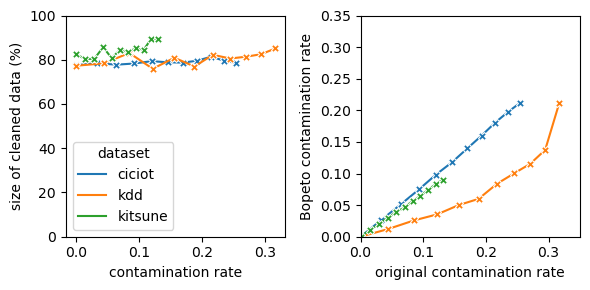

In [157]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
cond = data['dataset']=='ciciot'
sns.lineplot(data=data, x=data.r1, y=100*data.ratio, hue='dataset', ax=ax[0], marker='X')
#ax.set_title(f'{subplot}'.upper())
ax[0].set_xlabel('contamination rate') 
ax[0].set_ylabel('size of cleaned data (%)')
sns.lineplot(data=data, x=data.r1, y='r2', hue='dataset', ax=ax[1], marker='X')
ax[1].set_xlabel('original contamination rate') 
ax[1].set_ylabel('Bopeto contamination rate')
ax[1].legend().remove()
ax[0].set_ylim(0, 100)
ax[1].set_ylim(0, 0.35)
ax[1].set_xlim(0, 0.35)
plt.tight_layout()
plt.savefig("cleaning_ratio.pdf")
plt.show()

In [158]:
df_1 = pd.read_csv("performances_kdd_AE.csv")
df_2 = pd.read_csv("performances_kdd_OC-SVM.csv")
df_3 = pd.read_csv("performances_kdd_LOF.csv")
df_4 = pd.read_csv("performances_kdd_IF.csv")
df_kdd = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)

In [159]:
df_1 = pd.read_csv("performances_kitsune_AE.csv")
df_2 = pd.read_csv("performances_kitsune_OC-SVM.csv")
df_3 = pd.read_csv("performances_kitsune_LOF.csv")
df_4 = pd.read_csv("performances_kitsune_IF.csv")
df_kitsune = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)

In [160]:
df_1 = pd.read_csv("performances_ciciot_AE.csv")
#df_2 = pd.read_csv("performances_ciciot_OC-SVM.csv")
df_3 = pd.read_csv("performances_ciciot_LOF.csv")
df_4 = pd.read_csv("performances_ciciot_IF.csv")
df_ciciot = pd.concat([df_1, df_3, df_4], axis=0, ignore_index=True)

In [161]:
df = pd.concat([df_kdd, df_kitsune, df_ciciot], axis=0, ignore_index=True)
df = df.sort_values(by='dataset')

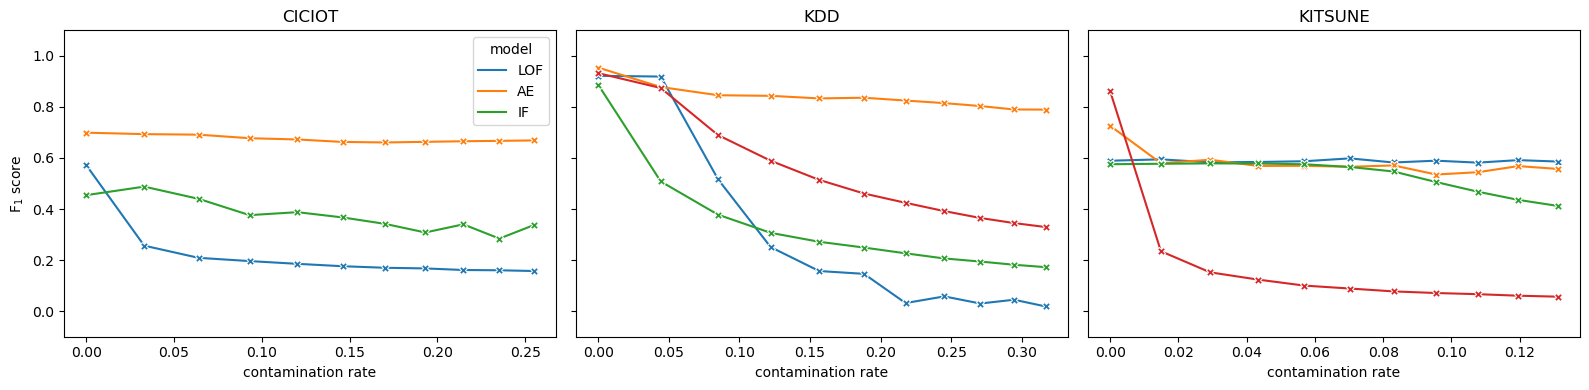

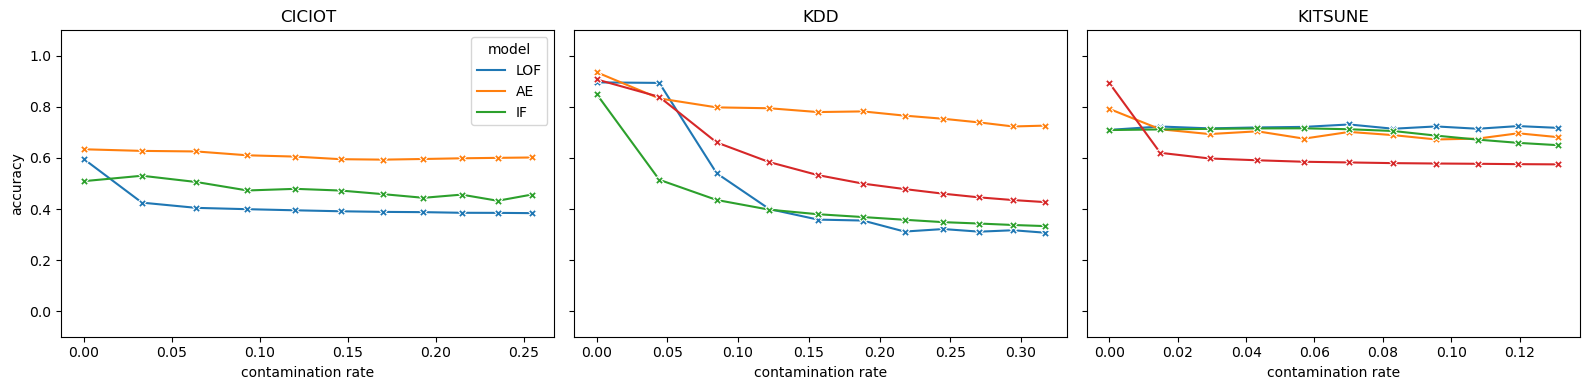

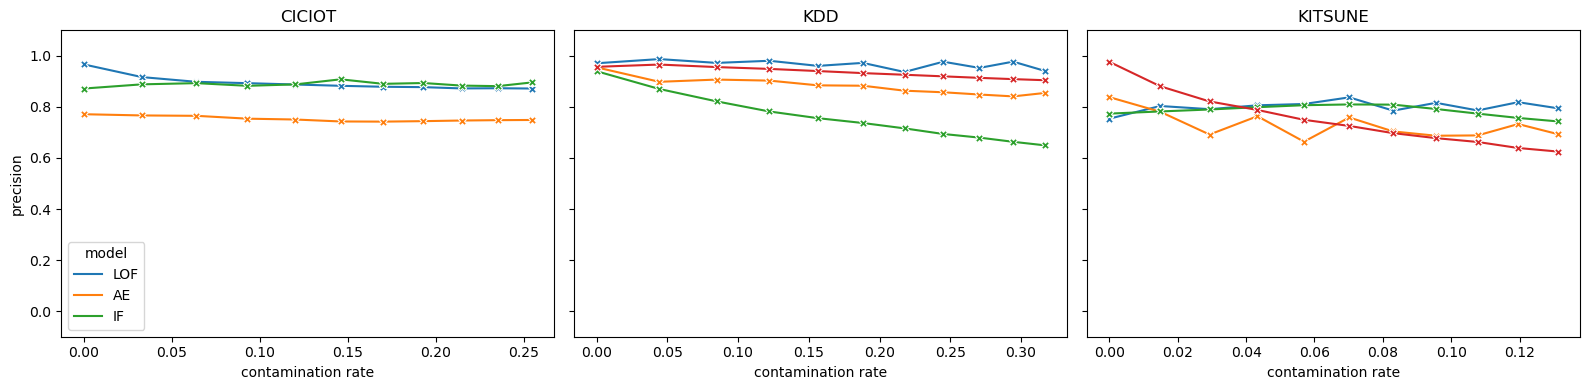

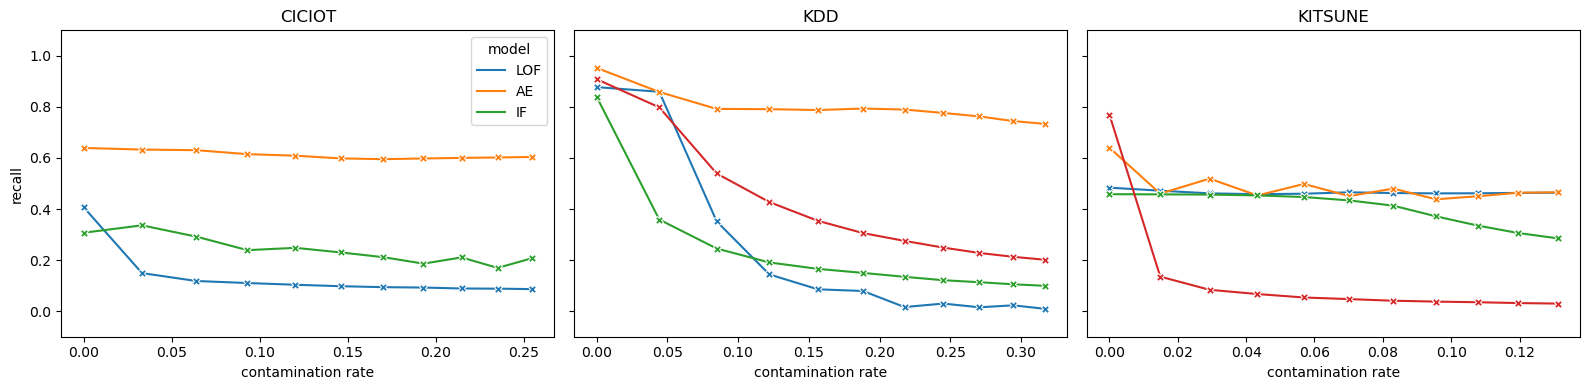

In [162]:
metrics = ["f1", "accuracy", "precision", "recall"]
for metric in metrics:
    degration = df[~df['model'].str.contains('Bopeto')]
    fig, axes = plt.subplots(ncols=3, figsize=(16, 4), sharey=True)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, degration.groupby('dataset'))):
        sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X')
        ax.set_title(f'{subplot}'.upper())
        ax.set_xlabel('contamination rate') 
        if metric=="f1":
            ax.set_ylabel(r'F$_1$ score')
        else:
            ax.set_ylabel(metric)
        ax.set_ylim(-0.1, 1.1)
        if i != 0:
            ax.legend().remove()
    plt.tight_layout()
    plt.savefig("degration_"+metric+".pdf")
    plt.show()

In [163]:
df[df['contamination']==0].head(10)

,dataset,contamination,model,accuracy,precision,recall,f1
209,ciciot,0.0,Bopeto_LOF,0.555958,0.955316,0.348637,0.510845
208,ciciot,0.0,LOF,0.595929,0.966523,0.406512,0.572313
207,ciciot,0.0,LOF,0.595929,0.966523,0.406512,0.572313
184,ciciot,0.0,AE,0.633277,0.770651,0.638655,0.698472
185,ciciot,0.0,AE,0.635030,0.772247,0.639964,0.699910
186,ciciot,0.0,Bopeto_AE,0.683622,0.804140,0.693103,0.744504
230,ciciot,0.0,IF,0.506937,0.860755,0.308533,0.454245
231,ciciot,0.0,IF,0.511646,0.883257,0.306170,0.454718
232,ciciot,0.0,Bopeto_IF,0.615739,0.826745,0.534159,0.649000
0,kdd,0.0,AE,0.935595,0.955105,0.952593,0.953847


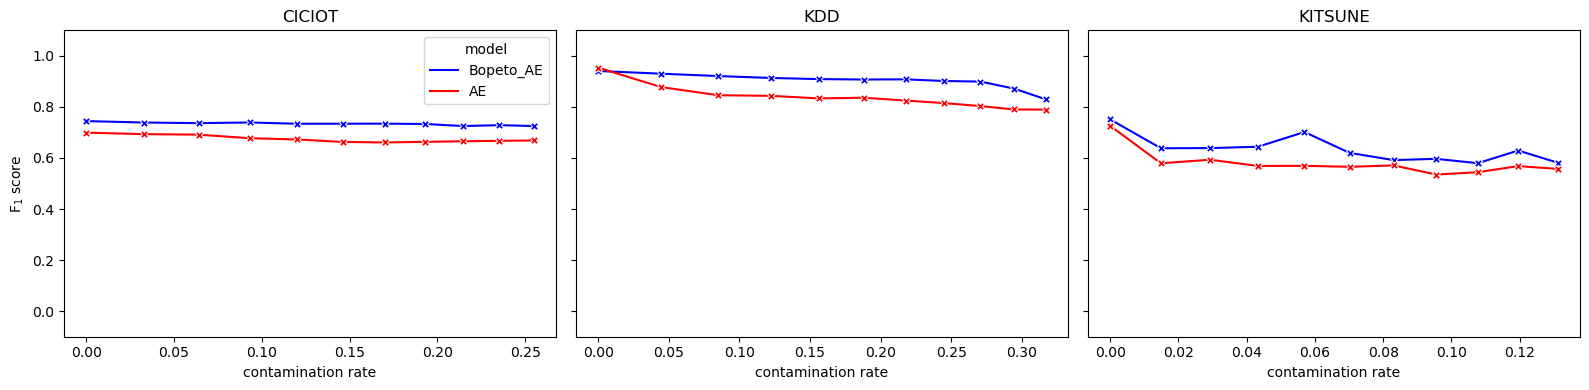

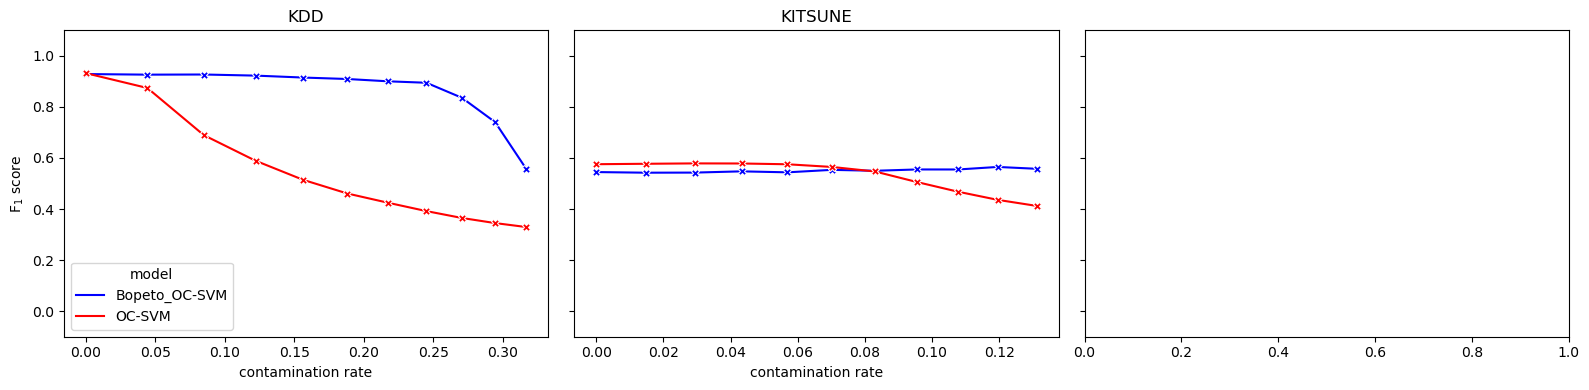

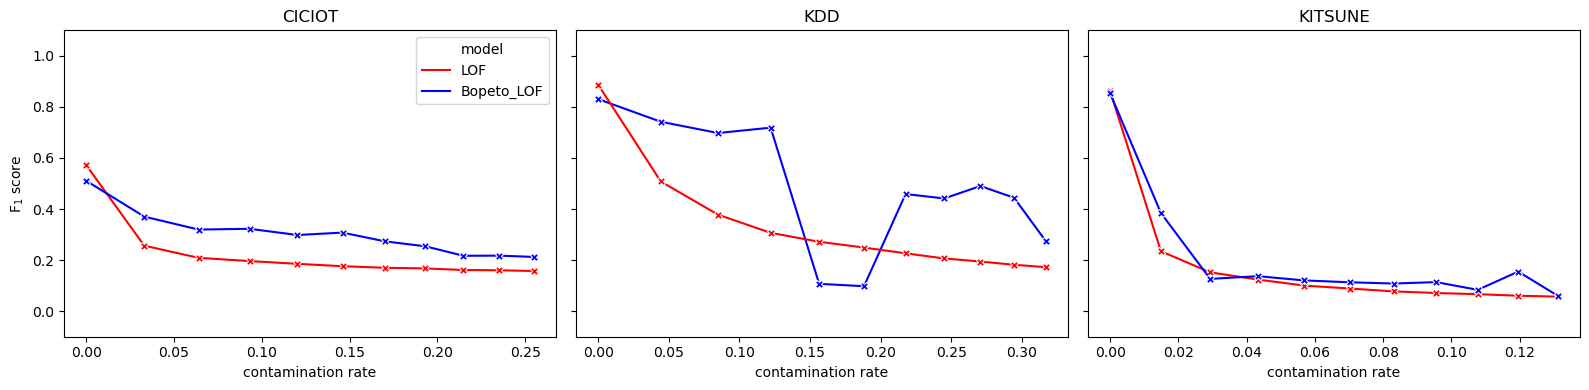

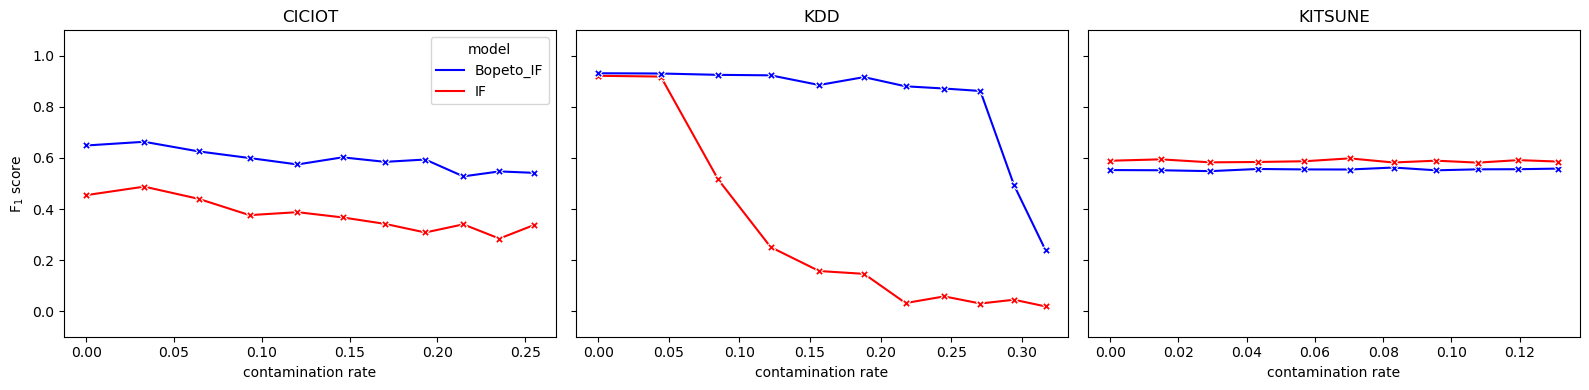

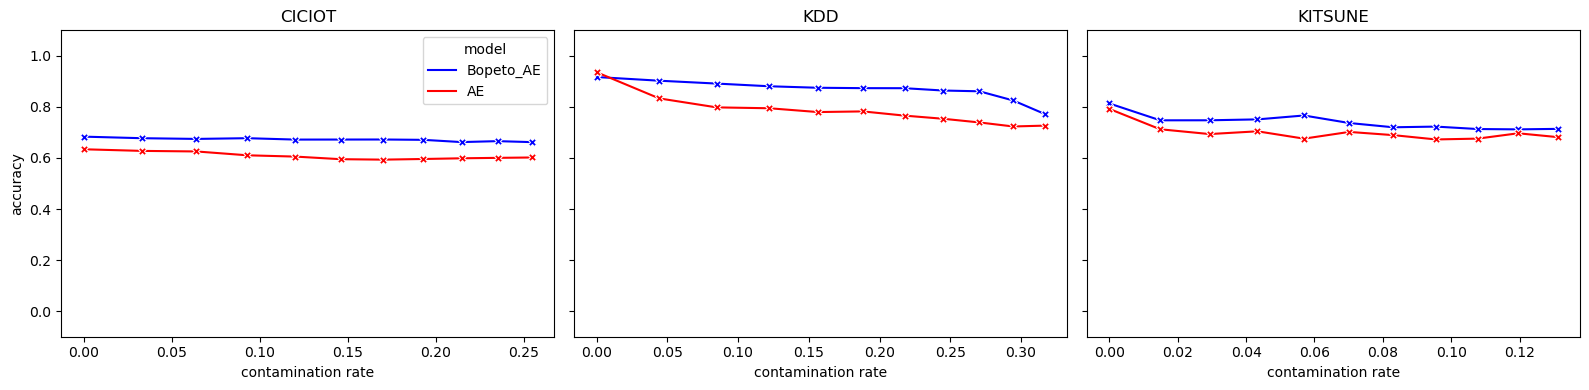

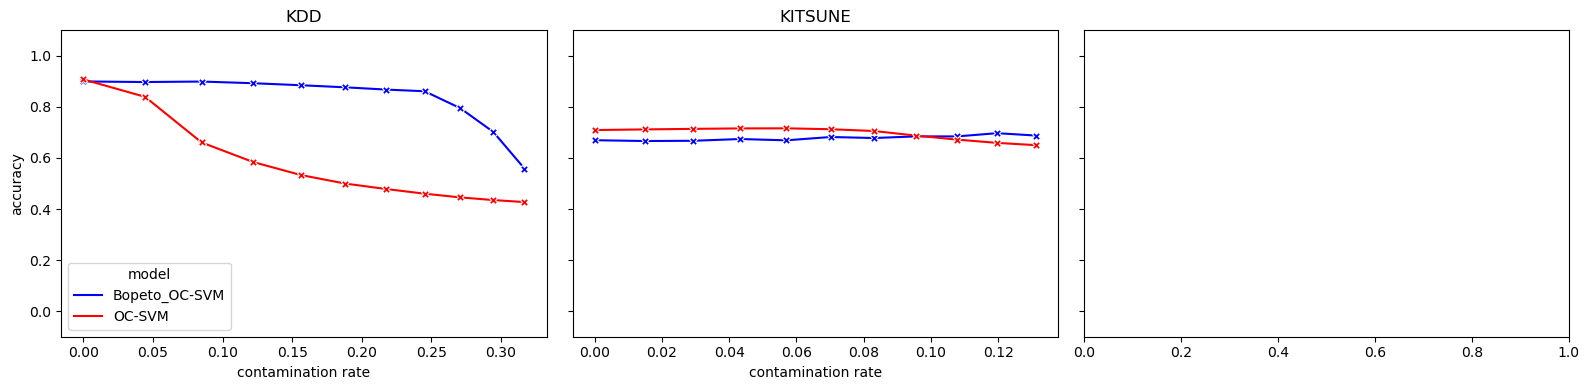

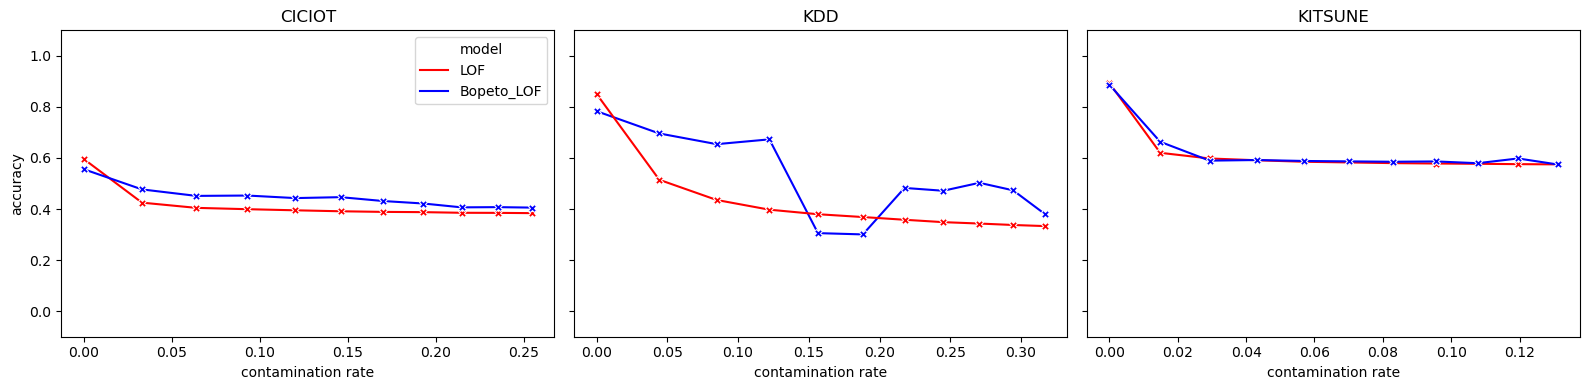

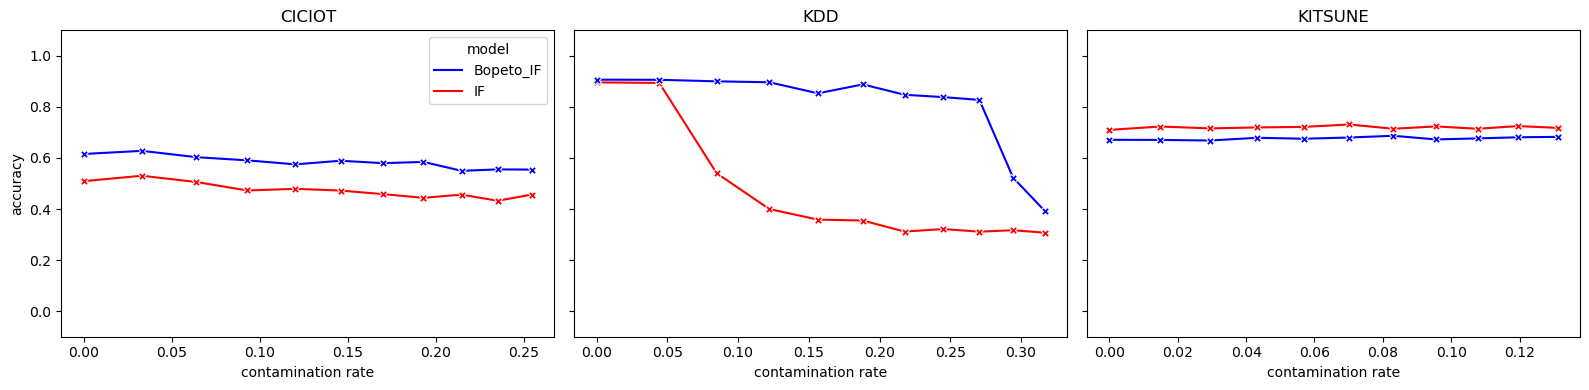

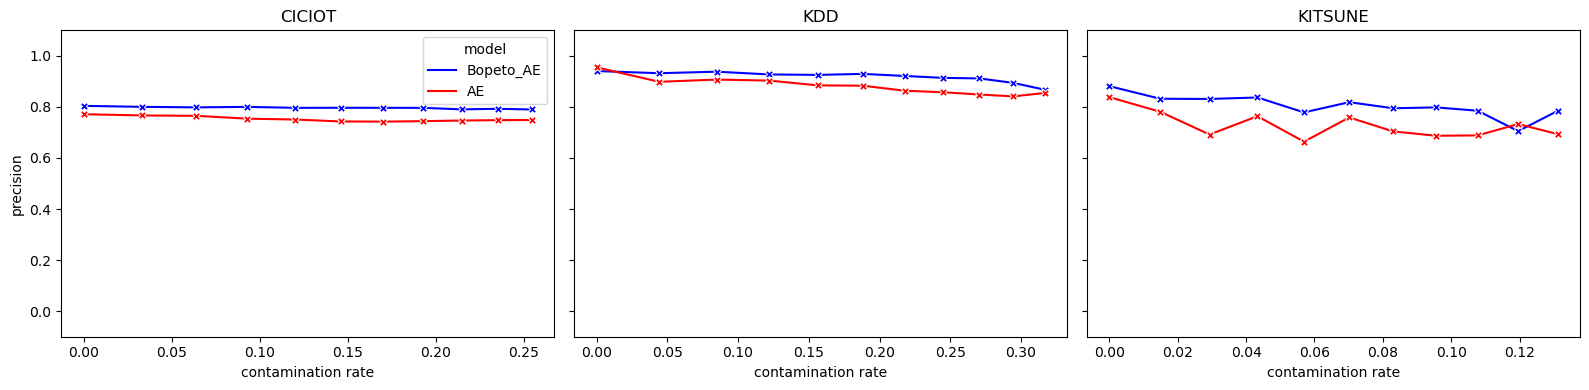

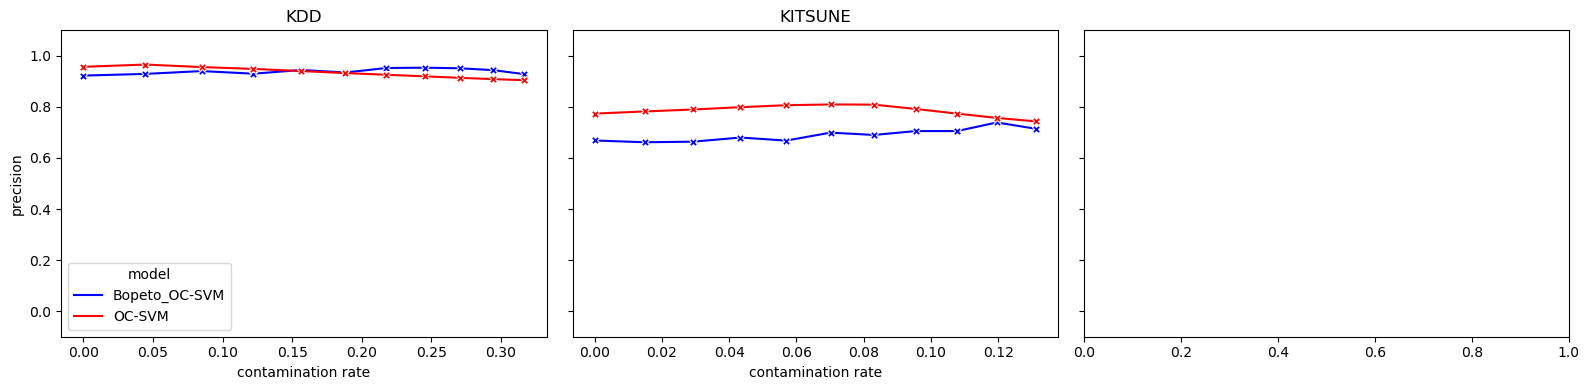

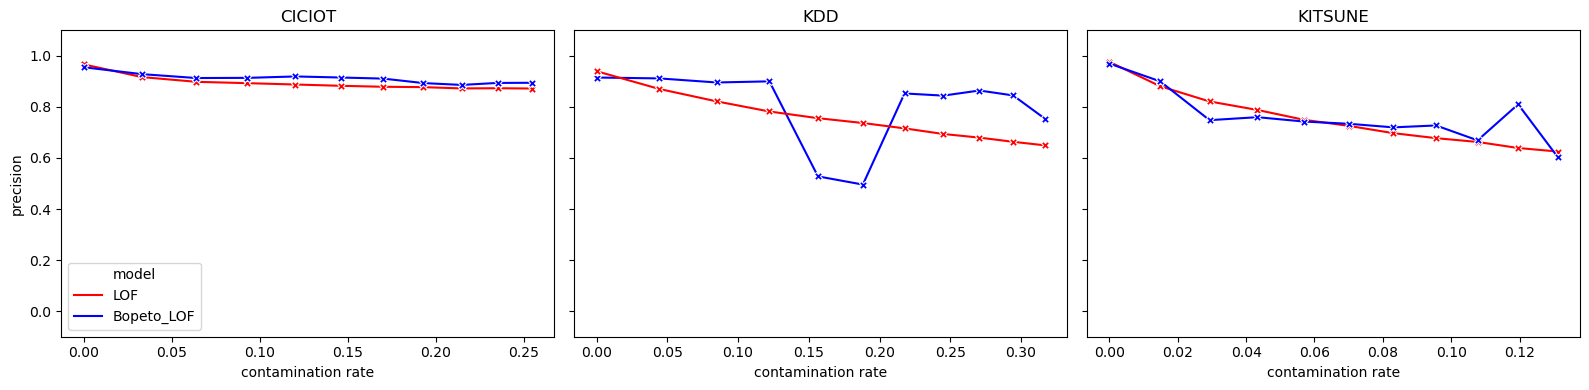

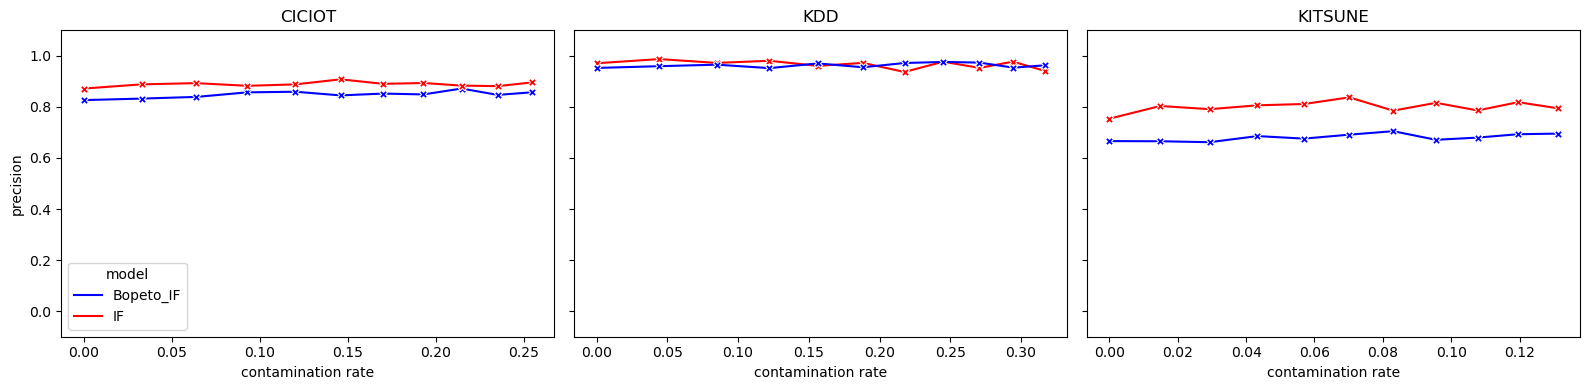

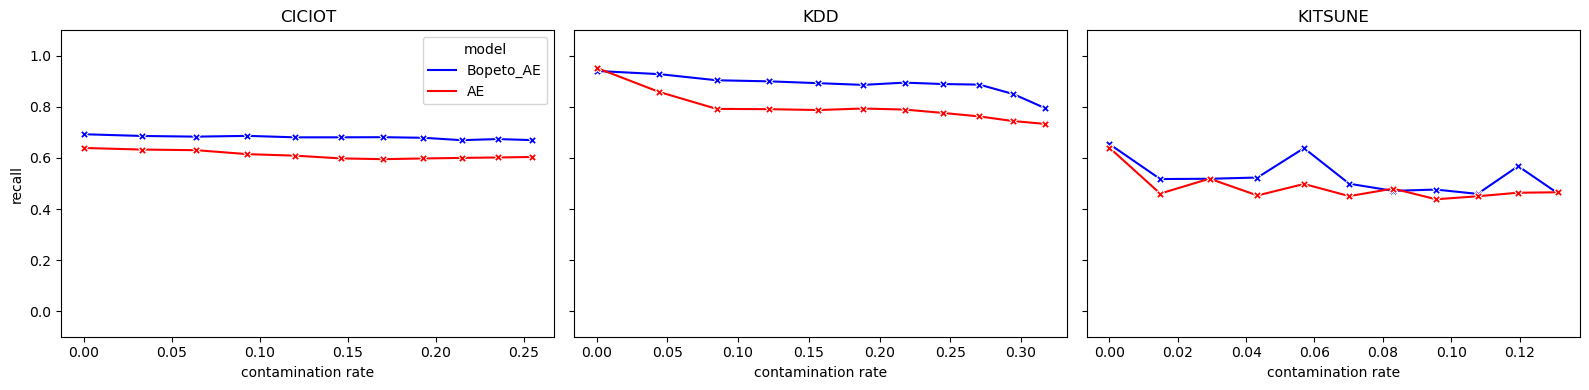

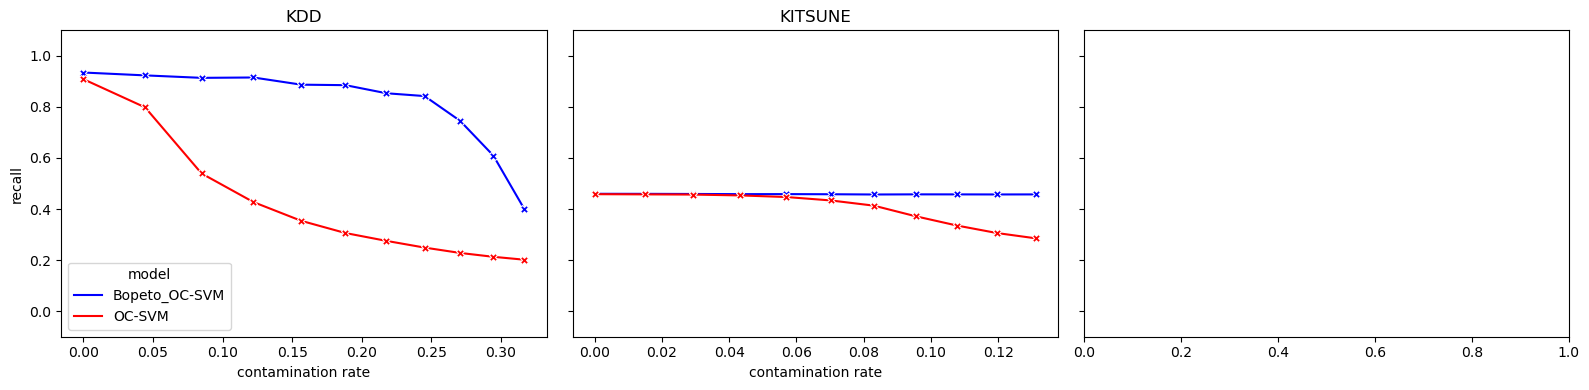

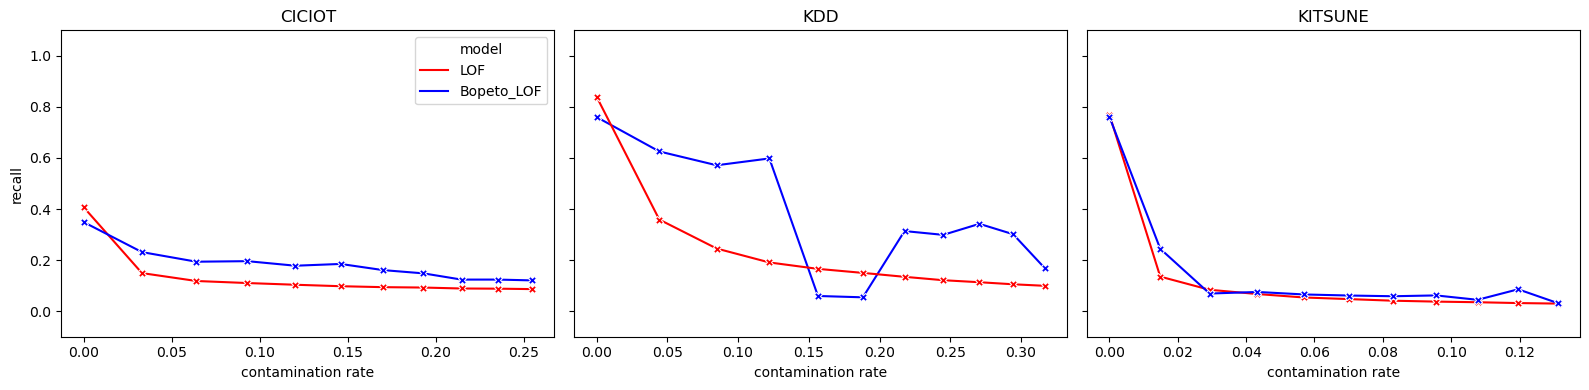

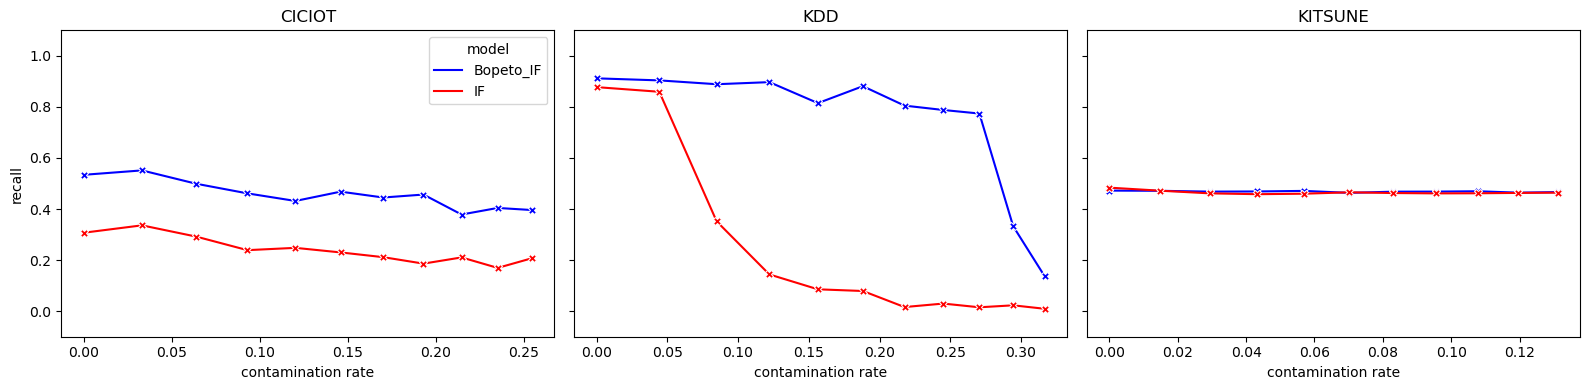

In [164]:
models = ["AE", "OC-SVM", "LOF", "IF"]
for metric in metrics:
    for model in models:
        palette ={'Bopeto_'+model: 'blue', model: 'red'}
        robustness = df[df['model'].str.contains(model)]
        robustness = robustness.sort_values(by='dataset')
        fig, axes = plt.subplots(ncols=3, figsize=(16, 4), sharey=True)
        for i, (ax, (subplot, df_group)) in enumerate(zip(axes, robustness.groupby('dataset'))):

            sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=palette)
            ax.set_title(f'{subplot}'.upper())
            ax.set_xlabel('contamination rate')
            if metric=="f1":
                ax.set_ylabel(r'F$_1$ score')
            else:
                ax.set_ylabel(metric)
            ax.set_ylim(-0.1, 1.1)

            if i != 0:
                ax.legend().remove()
        plt.tight_layout()
        plt.savefig(model+"_"+metric+"_robustness.pdf")
        plt.show()

In [ ]:
df_group

In [ ]:
data1 = pd.read_csv("kdd.csv")
#data2 = pd.read_csv("ids.csv")
data3 = pd.read_csv("ciciot.csv")
data4 = pd.read_csv("kitsune.csv")

In [ ]:

names = ['KDD', "CICIOT", "KITSUNE"]
datasets = [data1, data3, data4]
pca = PCA(n_components=2)
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
replacement_dict = {
    0: 'in',
    1: 'out',
    2: 'synthetic'
}
for i, xy in enumerate(datasets):
    
    x, y = xy.values[:, :-1], xy.values[:, -1]
    reduced_data = pca.fit_transform(x)
    df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
    df_pca['target'] = y
    df_pca['target'] = df_pca['target'].replace(replacement_dict)
    df_pca = df_pca[df_pca['target']!='synthetic']

    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target', ax=axs[i], palette={'normal':'blue', 'OoD':'red', 'synthetic':'green'}, legend=(i==0))
    axs[i].set_title(names[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    if i == 0:
        axs[i].legend(title='')
    else:
        axs[i].legend([],[], frameon=False)

plt.tight_layout()
plt.savefig("synthetic.png")
plt.show()


In [10]:
def sdc(dynamics):
    return np.std(np.diff(dynamics, axis=1), axis=1)

In [11]:
kdd_1 = np.loadtxt("kdd_FGM_sdc_ae_rate_0.18821442994855225.csv", delimiter=',')
ids_1 = np.loadtxt("ids_FGM_msc_ae_rate_0.16025228806568323.csv", delimiter=',')
ciciot_1 = np.loadtxt("ciciot_FGM_sdc_ae_rate_0.19310100024086915.csv", delimiter=',')
kitsune_1 = np.loadtxt("kitsune_FGM_sdc_ae_rate_0.0701628076642476.csv", delimiter=',')

In [61]:
x_kdd, y_kdd = kdd_1[:, :-1], kdd_1[:, -1]
x_ids, y_ids = ids_1[:, :-1], ids_1[:, -1]
x_ciciot, y_ciciot = ciciot_1[:, :-1], ciciot_1[:, -1]
x_kitsune, y_kitsune = kitsune_1[:, :-1], kitsune_1[:, -1]

In [90]:
m = 'score'
mac_kdd = sdc(x_kdd)
mac_ids = sdc(x_ids)
mac_ciciot = sdc(x_ciciot)
mac_kitsune = sdc(x_kitsune)

In [174]:
mapping = {0: 'in', 1: 'out', 2:'synthetic'}
def clean(dynamics, target, n=1000):
    detector = IsolationForest(n_estimators=50, random_state=42)
    df = pd.DataFrame(data = dynamics, columns=[m])
    df['class'] = target
    df['class'] = df['class'].replace(mapping)
    y_pred = detector.fit_predict(dynamics.reshape(-1, 1))
    anomaly_scores = detector.decision_function(dynamics.reshape(-1, 1))
    out = anomaly_scores[y_pred==-1]
    in_ = anomaly_scores[y_pred==1]
    threshold = (np.max(out)+np.min(in_))/2
    threshold = np.percentile(out, np.random.randint(60, 70, 1)[0])
    y_pred = anomaly_scores >= threshold

    df[m] = anomaly_scores
    y = y_pred==1
    sample = df.sample(n=n)
    selected = df.index.isin(sample.index)
    cleaned = df[y & selected].copy()
    return sample, cleaned, threshold 

In [175]:
all_data = [clean(mac_kdd, y_kdd), clean(mac_ciciot, y_ciciot), clean(mac_kitsune, y_kitsune)]


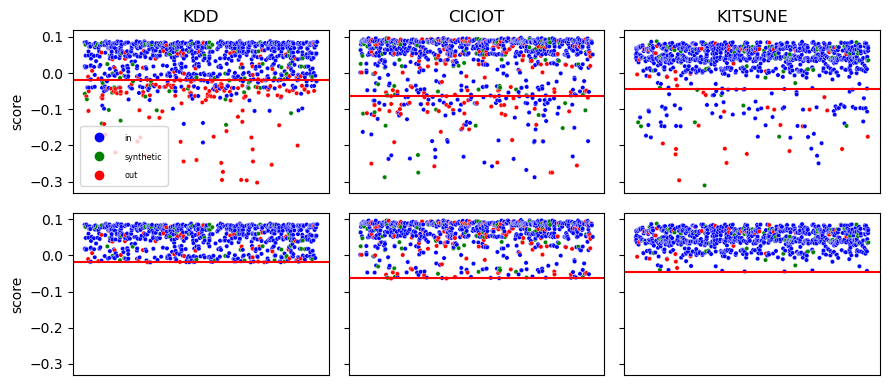

In [176]:
fig, axes = plt.subplots(2, 3, figsize=(9, 4), sharey=True)
datasets = ["KDD", "CICIOT", "KITSUNE"]
palette = {"out":"red", "synthetic":"green", "in":"blue"}
for i, df in enumerate(all_data):
    for j in range(2):
        d = df[j]
        
        d = d.sort_index()
        ax = axes[j, i]
        sns.scatterplot(data=d, x=d.index, y=m, hue='class', ax=ax, palette=palette, s=10)
        ax.axhline(y=df[2], color='r', linestyle='-')
        if j==0:
            ax.set_title(datasets[i])
        if i!=0 or j!=0:
            ax.legend().remove()
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
        
        ax.set_xticks([])
plt.tight_layout()
plt.savefig("dynamics_space.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
thresholds = [0.008, 0.015, 0.02]
for i, df in enumerate([df_kdd.sample(n=1000), df_ciciot.sample(n=1000), df_kitsune.sample(n=1000)]):
    ax = axes[i]
    sns.scatterplot(data=df, x=df.index, y=m, hue='class', ax=ax, palette=palette)
    ax.set_title(datasets[i])
    ax.axhline(y=thresholds[i], color='r', linestyle='-')
    if i!=0:
        ax.legend().remove()
    ax.set_xticks([])
plt.tight_layout()
plt.savefig("dynamics_space_threshold.png")
plt.show()


    